In [ ]:
import pandas as pd
from glob import glob
import habitat
from habitat.datasets import make_dataset

from habitat.core.dataset import Dataset, Episode, EpisodeIterator
import pickle





txts = glob('/home/motion/habitat-challenge/habitat-challenge-data/data/scene_datasets/hm3d/*/*/*.semantic.txt')
dfs = []
for txt in txts:
    df = pd.read_csv(txt,skiprows = 1,header = None)
    dfs.append(df)

In [ ]:
total_dfs = pd.concat(dfs).reset_index(drop = True)

In [ ]:
total_dfs.columns = ['item_index','mesh_id','name','class_id']
category_to_index = pickle.load(open('../category_to_index.pkl','rb'))

In [ ]:
# all_classes = total_dfs.name.unique()
# pickle.dump(all_classes,open('./all_classes.pkl','wb'))

In [ ]:
category_to_index

In [ ]:
total_dfs

# FMM debug

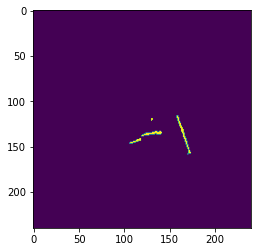

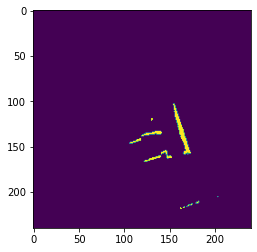

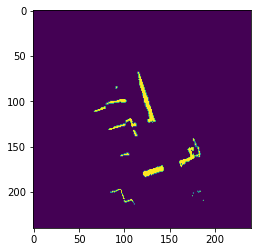

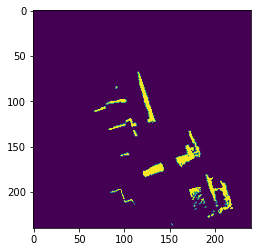

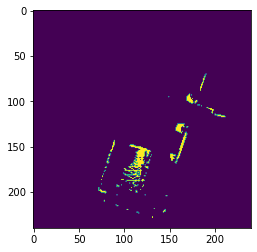

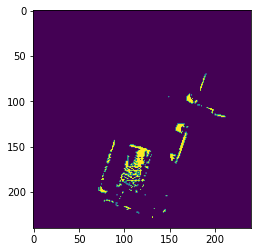

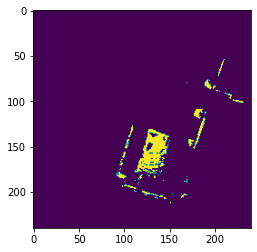

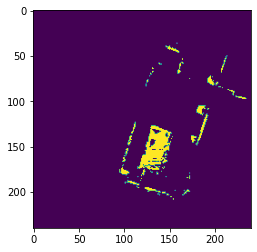

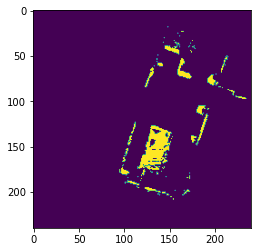

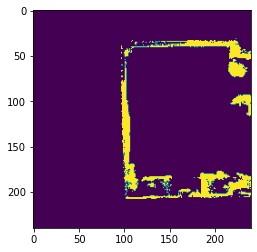

In [1]:
from envs.utils.fmm_planner import FMMPlanner

import math
import os
import cv2
import numpy as np
import skimage.morphology
from PIL import Image
from torchvision import transforms

from envs.utils.fmm_planner import FMMPlanner
from envs.habitat.objectgoal_env import ObjectGoal_Env
from agents.utils.semantic_prediction import SemanticPredMaskRCNN
from constants import color_palette
import envs.utils.pose as pu
import agents.utils.visualization as vu
import pickle
from agents.semantic_gt_loader import Semantic_env
from glob import glob
import time 
from matplotlib import pyplot as plt



maps = sorted(glob('/home/motion/data/semantic_evaluation_sem_exp/0.85/map/*.png'))

for m in maps[:10]:
    m = cv2.imread(m,cv2.IMREAD_GRAYSCALE)
    plt.imshow(m)
    plt.show()

In [2]:
m = cv2.imread(m,cv2.IMREAD_GRAYSCALE)
plt.imshow(m)

TypeError: Can't convert object to 'str' for 'filename'

In [3]:
planner = FMMPlanner(m)

In [4]:
%%time
planner.set_goal(goal = (75,150),auto_improve = True)
planner.get_short_term_goal([150,150])

TypeError: get_short_term_goal() missing 1 required positional argument: 'curr_loc'

In [5]:
skimage.morphology.disk(3)

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

In [ ]:
help(np.sort)

# Klampt 2D planning from image spaces

In [8]:
from OpenGL.GL import *
from OpenGL.GLU import *
from OpenGL.GLUT import *
import math
from klampt.plan.cspace import CSpace,MotionPlan,configurePlanner
from klampt.vis.glprogram import GLProgram
from klampt.vis.glcommon import GLWidgetPlugin
from klampt.math import vectorops,so2,so3,se3
import random

# problem = "1"
#problem = "2"
problem = "3"


class Circle:
    def __init__(self,x=0,y=0,radius=1):
        self.center = (x,y)
        self.radius = radius
        
    def contains(self,point):
        return (vectorops.distance(point,self.center) <= self.radius)

    def drawGL(self,res=0.01):
        numdivs = int(math.ceil(self.radius*math.pi*2/res))
        glBegin(GL_TRIANGLE_FAN)
        glVertex2f(*self.center)
        for i in xrange(numdivs+1):
            u = float(i)/float(numdivs)*math.pi*2
            glVertex2f(self.center[0]+self.radius*math.cos(u),self.center[1]+self.radius*math.sin(u))
        glEnd()

class CircleObstacleCSpace(CSpace):
    def __init__(self):
        CSpace.__init__(self)
        #set bounds
        self.bound = [(0.0,1.0),(0.0,1.0)]
        #set collision checking resolution
        self.eps = 1e-2
        #setup a robot with radius 0.05
        self.robot = Circle(0,0,0.05)
        #set obstacles here
        self.obstacles = []

    def addObstacle(self,circle):
        self.obstacles.append(circle)
    
    def feasible(self,q):
        #bounds test
        if not CSpace.feasible(self,q): return False
        #TODO: Problem 1: implement your feasibility tests here
        #currently, only the center is checked, so the robot collides
        #with boundary and obstacles
        for o in self.obstacles:
            if o.contains(q): return False
        return True

    def drawObstaclesGL(self):
        glColor3f(0.2,0.2,0.2)
        for o in self.obstacles:
            o.drawGL()

    def drawRobotGL(self,q):
        glColor3f(0,0,1)
        newc = vectorops.add(self.robot.center,q)
        c = Circle(newc[0],newc[1],self.robot.radius)
        c.drawGL()

class RigidBarCSpace(CSpace):
    """A SE(2) configuration space for a bar of length L"""
    def __init__(self):
        CSpace.__init__(self)
        #set bounds
        self.bound = [(0.0,1.0),(0.0,1.0),(0.0,math.pi*2)]
        #set collision checking resolution
        self.eps = 1e-3
        #setup a bar with length 0.1
        self.L = 0.1
        #set obstacles here
        self.obstacles = []

    def addObstacle(self,circle):
        self.obstacles.append(circle)

    def distance(self,a,b):
        # need to set the angle weight
        return vectorops.distance(a[:2],b[:2]) + abs(so2.diff(a[2],b[2]))*0.1

    def interpolate(self,a,b,u):
        return vectorops.interpolate(a[:2],b[:2],u) + [a[2] + u*so2.diff(b[2],a[2])]

    def endpoints(self,q):
        """Returns the bar's endpoints for the configuration q"""
        dx,dy = 0.5*self.L*math.cos(q[2]), 0.5*self.L*math.sin(q[2])
        p1 = (q[0]-dx,q[1]-dy)
        p2 = (q[0]+dx,q[1]+dy)
        return (p1,p2)
    
    def feasible(self,q):
        #bounds test
        if not CSpace.feasible(self,(q[0],q[1],0)): return False
        
        #get the endpoints of the bar
        p1,p2 = self.endpoints(q)
        if not CSpace.feasible(self,(p1[0],p1[1],0)): return False
        if not CSpace.feasible(self,(p2[0],p2[1],0)): return False
        #TODO: implement your feasibility test here: the current implementation
        #checks endpoints, but doesnt consider collisions with the
        #intermediate segment between the endpoints
        for o in self.obstacles:
            if o.contains(p1) or o.contains(p2): return False
        return True

    def drawObstaclesGL(self):
        glColor3f(0.2,0.2,0.2)
        for o in self.obstacles:
            o.drawGL()

    def drawRobotGL(self,q):
        #get the endpoints of the bar
        p1,p2 = self.endpoints(q)
        
        glColor3f(0,0,1)
        glLineWidth(5.0)
        glPointSize(8.0)
        glEnable(GL_POINT_SMOOTH)
        glBegin(GL_POINTS)
        glVertex2f(p1[0],p1[1])
        glVertex2f(p2[0],p2[1])
        glEnd()
        glBegin(GL_LINES)
        glVertex2f(p1[0],p1[1])
        glVertex2f(p2[0],p2[1])
        glEnd()
        glLineWidth(1.0)
        glPointSize(1.0)


class CSpaceObstacleProgram(GLProgram):
    def __init__(self,space,start=(0.1,0.5),goal=(0.9,0.5)):
        GLProgram.__init__(self)
        self.space = space
        self.start=start
        self.goal=goal
        
        costFunction = None

        #do you want an edge cost?
        def edgeCost(a,b):
            return (0.0+(0.5*(a[1]+b[1]) - 0.1)**2)*space.cspace.distance(a,b)
        def monotonicImprovementCost(a,b):
            if vectorops.distance(a,goal) < vectorops.distance(b,goal):
                return float('inf')
            else:
                return space.cspace.distance(a,b)
        costFunction = edgeCost
        #costFunction = monotonicImprovementCost

        goalcond = goal
        #testing planning to a set
        def inball(x):
            return space.cspace.distance(goal,x) < 0.2
        def ballsample():
            return [random.uniform(goal[i]-0.2,goal[i]+0.2) for i in range(len(self.space.bound))]
        #goalcond = inball
        #goalcond = (inball,ballsample)

        #testing planning to a lower-dimensional set with special sampling
        def inline(x):
            return x[0] == goal[0]
        def linesample():
            return [goal[0]] + [random.uniform(*self.space.bound[i]) for i in range(1,len(self.space.bound))]
        #goalcond = inline   #this will not work at all
        goalcond = (inline,linesample)

        self.optimizingPlanner = True
        self.planner,args = configurePlanner(space,start,goalcond,edgeCost=costFunction,optimizing=self.optimizingPlanner,
            type='auto')
        print("Planner configured as",args)
    
        self.path = []
        self.G = None
        
    def keyboardfunc(self,key,x,y):
        if key==' ':
            if self.optimizingPlanner or not self.path:
                print( "Planning 1...")
                self.planner.planMore(1)
                self.path = self.planner.getPath()
                self.G = self.planner.getRoadmap()
                print( "Planner stats:",self.planner.getStats())
                if self.path:
                    print( "Optimal path cost",self.planner.pathCost(self.path))
                self.refresh()
        elif key=='p':
            if self.optimizingPlanner or not self.path:
                print( "Planning 100...")
                self.planner.planMore(100)
                self.path = self.planner.getPath()
                self.G = self.planner.getRoadmap()
                print( "Planner stats:",self.planner.getStats())
                if self.path:
                    print( "Optimal path cost",self.planner.pathCost(self.path))
                self.refresh()
       
    def display(self):
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        glOrtho(0,1,1,0,-1,1);
        glMatrixMode(GL_MODELVIEW)
        glLoadIdentity()

        glDisable(GL_LIGHTING)
        self.space.drawObstaclesGL()
        if self.path:
            #draw path
            glColor3f(0,1,0)
            glBegin(GL_LINE_STRIP)
            for q in self.path:
                glVertex2f(q[0],q[1])
            glEnd()
            for q in self.path:
                self.space.drawRobotGL(q)
        else:
            self.space.drawRobotGL(self.start)
            self.space.drawRobotGL(self.goal)

        if self.G:
            #draw graph
            V,E = self.G
            glEnable(GL_BLEND)
            glBlendFunc(GL_SRC_ALPHA,GL_ONE_MINUS_SRC_ALPHA)
            glColor4f(0,0,0,0.5)
            glPointSize(3.0)
            glBegin(GL_POINTS)
            for v in V:
                glVertex2f(v[0],v[1])
            glEnd()
            glColor4f(0.5,0.5,0.5,0.5)
            glBegin(GL_LINES)
            for (i,j) in E:
                glVertex2f(V[i][0],V[i][1])
                glVertex2f(V[j][0],V[j][1])
            glEnd()
            glDisable(GL_BLEND)

class RigidObjectCSpacePlugin(GLWidgetPlugin):
    def __init__(self,world,object):
        GLWidgetPlugin.__init__(self)

        from klampt.model.collide import WorldCollider
        from klampt.plan.rigidobjectcspace import RigidObjectCSpace
        from klampt import ObjectPoser
        self.world = world
        self.object = object
        self.space = RigidObjectCSpace(object,collider=WorldCollider(world))
        
        self.costFunction = None
        self.start = None
        self.goal = None

        self.startWidget = ObjectPoser(self.object)
        self.goalWidget = ObjectPoser(self.object)
        self.addWidget(self.startWidget)
        self.addWidget(self.goalWidget)

        self.optimizingPlanner = True
        self.path = []
        self.G = None

    def makePlanner(self):
        self.planner,args = configurePlanner(self.space,self.start,self.goal,
            edgeCost=self.costFunction,optimizing=self.optimizingPlanner,
            type='auto')
        print( "Planner configured as",args)
    
        self.path = []
        self.G = None
    
    def initialize(self):
        return True

    def keyboardfunc(self,key,x,y):
        if key==' ':
            if self.start is None or self.goal is None:
                self.start = self.space.transformToConfig(self.startWidget.get())
                self.goal = self.space.transformToConfig(self.goalWidget.get())
                self.makePlanner()

            if self.optimizingPlanner or not self.path:
                print( "Planning 1...")
                self.planner.planMore(1)
                self.path = self.planner.getPath()
                self.G = self.planner.getRoadmap()
                print( "Planner stats:",self.planner.getStats())
                if self.path:
                    print( "Optimal path cost",self.planner.pathCost(self.path))
                self.refresh()
        elif key=='p':
            if self.start is None or self.goal is None:
                self.start = self.space.transformToConfig(self.startWidget.get())
                self.goal = self.space.transformToConfig(self.goalWidget.get())
                self.makePlanner()

            if self.optimizingPlanner or not self.path:
                print( "Planning 100...")
                self.planner.planMore(100)
                self.path = self.planner.getPath()
                self.G = self.planner.getRoadmap()
                print( "Planner stats:",self.planner.getStats())
                if self.path:
                    print( "Optimal path cost",self.planner.pathCost(self.path))
                self.refresh()
        elif key == 'r':
            self.planner = None
            self.start = None
            self.goal = None
            self.path = []
            self.G = None
            self.refresh()
            
        else:
            print( "key",key)
    

    def display(self):
        GLWidgetPlugin.display(self)

        glEnable(GL_LIGHTING)
        for i in range(self.world.numRobots()):
            self.world.robot(i).drawGL()
        for i in range(self.world.numRigidObjects()):
            if i != self.object.index:
                self.world.rigidObject(i).drawGL()
        for i in range(self.world.numTerrains()):
            self.world.terrain(i).drawGL()

        self.object.setTransform(*self.startWidget.get())
        self.object.drawGL()

        self.object.setTransform(*self.goalWidget.get())
        self.object.drawGL()

        if self.path:
            #draw path
            glDisable(GL_LIGHTING)
            glColor3f(0,1,0)
            glBegin(GL_LINE_STRIP)
            for q in self.path:
                glVertex3f(q[0],q[1],q[2])
            glEnd()
            glEnable(GL_LIGHTING)
            for q in self.path:
                self.object.setTransform(*self.space.configToTransform(q))
                self.object.drawGL()
        else:
            if self.start:
                self.object.setTransform(*self.space.configToTransform(self.start))
                self.object.drawGL()
            if self.goal:
                self.object.setTransform(*self.space.configToTransform(self.goal))
                self.object.drawGL()

        if self.G:
            #draw graph
            V,E = self.G
            glDisable(GL_LIGHTING)
            glEnable(GL_BLEND)
            glBlendFunc(GL_SRC_ALPHA,GL_ONE_MINUS_SRC_ALPHA)
            glColor4f(0,0,0,0.5)
            glPointSize(3.0)
            glBegin(GL_POINTS)
            for v in V:
                glVertex3f(v[0],v[1],v[2])
            glEnd()
            glColor4f(0.5,0.5,0.5,0.5)
            glBegin(GL_LINES)
            for (i,j) in E:
                glVertex3f(V[i][0],V[i][1],V[i][2])
                glVertex3f(V[j][0],V[j][1],V[j][2])
            glEnd()
            glDisable(GL_BLEND)
            glEnable(GL_LIGHTING)
        return True

if __name__=='__main__':
    if problem == "3":
        from klampt import WorldModel
        from klampt import vis
        world = WorldModel()
        world.readFile("../../data/tx90cuptable.xml")
        plugin = RigidObjectCSpacePlugin(world,world.rigidObject(0))
        vis.setWindowTitle("Rigid object planning")
        vis.run(plugin)
        exit()
    space = None
    start = None
    goal = None
    if problem == "1":
        space = CircleObstacleCSpace()
        space.addObstacle(Circle(0.5,0.5,0.36))
        start=(0.06,0.5)
        goal=(0.94,0.5)
    elif problem == "2":
        space = RigidBarCSpace()
        space.addObstacle(Circle(0.5,0.5,0.4))
        start=(0.1,0.1,0.0)
        goal=(0.9,0.9,6.20)
    program = CSpaceObstacleProgram(space,start,goal)
    program.view.w = program.view.h = 640
    program.name = "Motion planning test"
    program.run()

RuntimeError: Invalid rigid object index